In [16]:
import cv2
import glob
import numpy as np
import pickle
import os

# 棋盘规格
BOARD_RAW = 9
BOARD_COL = 6

# 图片保存路径
IMG_SAVE_PATH = "img/"
IMG_RESULT_PATH = "result/"

if __name__ == '__main__':
    # 创建result文件夹（如果不存在）
    if not os.path.exists(IMG_RESULT_PATH):
        os.makedirs(IMG_RESULT_PATH)
        
    obj_p = np.zeros((BOARD_RAW*BOARD_COL, 3), np.float32)

    # np.mgrid[0:raw, 0:col]的shape为(2, 9, 6)转置后为(6, 9, 2)，reshape后为(6*9, 2)
    # obj_p[:, :2]===>obj_p[:, 0] and obj_p[:, 1]
    obj_p[:, :2] = np.mgrid[0:BOARD_RAW, 0:BOARD_COL].T.reshape(-1, 2)

    obj_points = []
    img_points = []

    images = glob.glob(IMG_SAVE_PATH + '*.jpg')
    images = sorted(set(images), key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
    
    print(f"找到 {len(images)} 张图片")
    successful_detections = 0
    
    for name in images:
        print(f'正在处理: {os.path.basename(name)}')
        img = cv2.imread(name)
        
        if img is None:
            print(f"  ✗ 无法读取图片: {name}")
            continue
            
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 寻找角点
        ret, corners = cv2.findChessboardCorners(gray, (BOARD_RAW, BOARD_COL), None)
        
        # 重要：只有在成功找到角点时才进行后续处理
        if ret and corners is not None:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            sub_corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            obj_points.append(obj_p)
            img_points.append(sub_corners)

            # 在彩色图像上绘制角点
            img_with_corners = cv2.drawChessboardCorners(img.copy(), (BOARD_RAW, BOARD_COL), sub_corners, ret)
            
            # 保存带角点的图像
            result_filename = 'detected_' + os.path.basename(name)
            cv2.imwrite(IMG_RESULT_PATH + result_filename, img_with_corners)
            cv2.waitKey(500)
            
            successful_detections += 1
        else:
            print("未检测到角点")

    cv2.destroyAllWindows()
    
    print(f"\n处理完成: {successful_detections}/{len(images)} 张图片成功检测到角点")

    if successful_detections == 0:
        print("错误：没有成功检测到任何角点！")
        exit()

    print("\n开始相机标定...")

    # 标定结果：相机的内参数矩阵，畸变系数，旋转矩阵和平移向量
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    
    print('标定成功!')
    print('重投影误差 (越小越好):', ret)
    print('\n相机内参矩阵:')
    print(mtx)
    print('\n畸变系数:')
    print(dist)

    # 保存参数
    cal_parameter = {'ret': ret, 'mtx': mtx, 'dist': dist, 'rvecs': rvecs, 'tvecs': tvecs}
    
    # 文件保存
    with open("camera_parameters.pkl", "wb") as f:
        pickle.dump(cal_parameter, f)
    print("\n参数保存成功: camera_parameters.pkl")

    print("\n标定完成！")

找到 11 张图片
正在处理: 1.jpg
正在处理: 2.jpg
正在处理: 2.jpg
正在处理: 3.jpg
未检测到角点
正在处理: 4.jpg
正在处理: 3.jpg
未检测到角点
正在处理: 4.jpg
未检测到角点
正在处理: 5.jpg
未检测到角点
正在处理: 5.jpg
正在处理: 6.jpg
正在处理: 6.jpg
正在处理: 7.jpg
正在处理: 7.jpg
正在处理: 8.jpg
正在处理: 8.jpg
正在处理: 9.jpg
正在处理: 9.jpg
正在处理: 10.jpg
正在处理: 10.jpg
正在处理: 11.jpg
正在处理: 11.jpg

处理完成: 9/11 张图片成功检测到角点

开始相机标定...
标定成功!
重投影误差 (越小越好): 0.5836025589343484

相机内参矩阵:
[[1.14945238e+03 0.00000000e+00 9.25887407e+02]
 [0.00000000e+00 1.14715556e+03 5.35470984e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

畸变系数:
[[-0.35771687  0.18385165 -0.00058972  0.00059129 -0.05944617]]

参数保存成功: camera_parameters.pkl

标定完成！

处理完成: 9/11 张图片成功检测到角点

开始相机标定...
标定成功!
重投影误差 (越小越好): 0.5836025589343484

相机内参矩阵:
[[1.14945238e+03 0.00000000e+00 9.25887407e+02]
 [0.00000000e+00 1.14715556e+03 5.35470984e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

畸变系数:
[[-0.35771687  0.18385165 -0.00058972  0.00059129 -0.05944617]]

参数保存成功: camera_parameters.pkl

标定完成！


In [17]:
import cv2
import pickle
import glob
import os

# 创建输出文件夹
if not os.path.exists('processed'):
    os.makedirs('processed')

# 读取相机参数
f = pickle.load(open('camera_parameters.pkl', 'rb'))
mtx, dist = f['mtx'], f['dist']

# 处理所有图片
images = glob.glob('img/*.jpg') + glob.glob('img/*.png')
print(f"找到 {len(images)} 张图片")

for img_path in images:
    # 读取图片
    img = cv2.imread(img_path)
    
    # 畸变校正
    corrected = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 保存到processed文件夹
    filename = os.path.basename(img_path)
    output_path = f'processed/{filename}'
    cv2.imwrite(output_path, corrected)
    
    print(f"✓ {filename}")

找到 11 张图片
✓ 1.jpg
✓ 10.jpg
✓ 11.jpg
✓ 2.jpg
✓ 3.jpg
✓ 4.jpg
✓ 5.jpg
✓ 2.jpg
✓ 3.jpg
✓ 4.jpg
✓ 5.jpg
✓ 6.jpg
✓ 7.jpg
✓ 8.jpg
✓ 9.jpg
✓ 6.jpg
✓ 7.jpg
✓ 8.jpg
✓ 9.jpg


In [18]:
import pickle
import numpy as np

# 读取相机标定参数
f = pickle.load(open('camera_parameters.pkl', 'rb'))
mtx, dist = f['mtx'], f['dist']

# 提取相机内参
fx = mtx[0, 0]  # 焦距x
fy = mtx[1, 1]  # 焦距y
cx = mtx[0, 2]  # 主点x
cy = mtx[1, 2]  # 主点y

# 提取畸变系数 (dist是2D数组)
k1 = dist[0][0]    # 径向畸变系数1
k2 = dist[0][1]    # 径向畸变系数2
p1 = dist[0][2]    # 切向畸变系数1
p2 = dist[0][3]    # 切向畸变系数2
k3 = dist[0][4] if dist.shape[1] > 4 else 0  # 径向畸变系数3

print("相机内参:")
print(f"fx = {fx:.6f}")
print(f"fy = {fy:.6f}")
print(f"cx = {cx:.6f}")
print(f"cy = {cy:.6f}")
print()
print("畸变系数:")
print(f"k1 = {k1:.6f}")
print(f"k2 = {k2:.6f}")
print(f"k3 = {k3:.6f}")
print(f"p1 = {p1:.6f}")
print(f"p2 = {p2:.6f}")

相机内参:
fx = 1149.452376
fy = 1147.155560
cx = 925.887407
cy = 535.470984

畸变系数:
k1 = -0.357717
k2 = 0.183852
k3 = -0.059446
p1 = -0.000590
p2 = 0.000591


In [36]:
print("使用控制点网格拟合多项式系数...")

# 图像尺寸
img_width, img_height = 1280, 720

# 生成更密集的控制点网格以提高拟合精度
grid_points_x = 40  # 增加网格密度 
grid_points_y = 30
x_grid = np.linspace(0, img_width-1, grid_points_x)
y_grid = np.linspace(0, img_height-1, grid_points_y)

# 创建控制点 - 修正映射方向
src_points = []  # 校正后的点（输入）
dst_points = []  # 畸变的点（输出）

for y in y_grid:
    for x in x_grid:
        # 校正后的点作为输入
        src_points.append([x, y])
        
        # 计算对应的畸变点：先去畸变再加畸变
        point = np.array([[[x, y]]], dtype=np.float32)
        # 先标准化到相机坐标
        x_norm = (x - cx) / fx
        y_norm = (y - cy) / fy
        
        # 应用更精确的畸变模型，包括更高阶项
        r2 = x_norm**2 + y_norm**2
        r4 = r2**2
        r6 = r2**3
        
        # 径向畸变 - 包含更高阶项提高精度
        radial = 1 + k1*r2 + k2*r4 + k3*r6
        
        # 切向畸变 - 完整计算
        tangential_x = 2*p1*x_norm*y_norm + p2*(r2 + 2*x_norm**2)
        tangential_y = p1*(r2 + 2*y_norm**2) + 2*p2*x_norm*y_norm
        
        x_distorted = x_norm*radial + tangential_x
        y_distorted = y_norm*radial + tangential_y
        
        # 转回像素坐标
        x_pixel = x_distorted * fx + cx
        y_pixel = y_distorted * fy + cy
        
        dst_points.append([x_pixel, y_pixel])

src_points = np.array(src_points)
dst_points = np.array(dst_points)

print(f"生成了 {len(src_points)} 个控制点")

# 构建多项式特征矩阵 A (对应MATLAB中的矩阵构建)
def build_polynomial_matrix(points):
    """构建四次多项式特征矩阵"""
    n_points = len(points)
    A = np.zeros((n_points, 15))
    
    for i, (x, y) in enumerate(points):
        # 按照MATLAB代码顺序：1, x, y, x², xy, y², x³, x²y, xy², y³, x⁴, x³y, x²y², xy³, y⁴
        A[i] = [1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, x**4, x**3*y, x**2*y**2, x*y**3, y**4]
    
    return A

# 构建特征矩阵并求解 - 添加正则化提高稳定性
A = build_polynomial_matrix(src_points)

# 使用岭回归(Ridge Regression)提高数值稳定性
alpha = 1e-6  # 正则化参数
ATA = A.T @ A
I = np.eye(ATA.shape[0])

x_coeffs = np.linalg.solve(ATA + alpha * I, A.T @ dst_points[:, 0])
y_coeffs = np.linalg.solve(ATA + alpha * I, A.T @ dst_points[:, 1])

print("多项式拟合完成!")
print("X方向系数:", x_coeffs)
print("Y方向系数:", y_coeffs)

# 应用放大倍数
scale_factors = [4, 15, 25, 36, 46]
term_degrees = [0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4]
x_coeffs_scaled = [coeff * scale_factors[degree] for coeff, degree in zip(x_coeffs, term_degrees)]
y_coeffs_scaled = [coeff * scale_factors[degree] for coeff, degree in zip(y_coeffs, term_degrees)]

# 转换为18bit有符号数并输出系数
def to_18bit_signed_hex(coeff):
    """转换为18bit有符号数的16进制小写，直接使用整数部分"""
    if abs(coeff) < 1e-15:
        return "0"
    # 直接取整数部分，不做定点数转换
    fixed_point = int(coeff)
    # 18bit有符号数范围：-131072 to 131071
    fixed_point = max(-131072, min(131071, fixed_point))
    # 转换为18bit补码
    if fixed_point < 0:
        fixed_point = (1 << 18) + fixed_point
    return f"{fixed_point:x}"

term_names = ['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14']

print("// X方向映射系数 (18bit有符号数)")
for name, coeff in zip(term_names, x_coeffs_scaled):
    hex_val = to_18bit_signed_hex(coeff)
    print(f"{name} = {hex_val}")

print("\n// Y方向映射系数 (18bit有符号数)")  
for name, coeff in zip(term_names, y_coeffs_scaled):
    hex_val = to_18bit_signed_hex(coeff)
    print(f"{name.replace('a', 'b')} = {hex_val}")

# 拟合精度
pred_x = A @ x_coeffs
pred_y = A @ y_coeffs
error_x = np.mean(np.abs(pred_x - dst_points[:, 0]))
error_y = np.mean(np.abs(pred_y - dst_points[:, 1]))
print(f"\n拟合精度: X误差{error_x:.3f}像素, Y误差{error_y:.3f}像素")

# 改进的多项式校正函数 - 使用全部15项和更好的插值
def apply_polynomial_correction(img, x_coeffs, y_coeffs):
    """高精度多项式畸变校正函数"""
    height, width = img.shape[:2]
    corrected_img = np.zeros_like(img)
    
    for y in range(height):
        for x in range(width):
            # 计算完整的4次多项式映射
            x_terms = [1, x, y, x**2, x*y, y**2, x**3, x**2*y, x*y**2, y**3, 
                      x**4, x**3*y, x**2*y**2, x*y**3, y**4]
            y_terms = x_terms  # 相同的特征向量
            
            x_src = sum(coeff * term for coeff, term in zip(x_coeffs, x_terms))
            y_src = sum(coeff * term for coeff, term in zip(y_coeffs, y_terms))
            
            # 双线性插值 - 更精确的边界处理
            x0, y0 = int(np.floor(x_src)), int(np.floor(y_src))
            x1, y1 = x0 + 1, y0 + 1
            
            if 0 <= x0 < width-1 and 0 <= y0 < height-1:
                # 计算插值权重
                wx = x_src - x0
                wy = y_src - y0
                
                # 确保权重在[0,1]范围内
                wx = np.clip(wx, 0, 1)
                wy = np.clip(wy, 0, 1)
                
                # 双线性插值 - 处理RGB三通道
                if len(img.shape) == 3:
                    for c in range(img.shape[2]):
                        corrected_img[y, x, c] = (
                            img[y0, x0, c] * (1-wx) * (1-wy) +
                            img[y0, x1, c] * wx * (1-wy) +
                            img[y1, x0, c] * (1-wx) * wy +
                            img[y1, x1, c] * wx * wy
                        )
                else:
                    corrected_img[y, x] = (
                        img[y0, x0] * (1-wx) * (1-wy) +
                        img[y0, x1] * wx * (1-wy) +
                        img[y1, x0] * (1-wx) * wy +
                        img[y1, x1] * wx * wy
                    )
    
    return corrected_img

使用控制点网格拟合多项式系数...
生成了 1200 个控制点
多项式拟合完成!
X方向系数: [ 1.95663577e+02  5.73718441e-01 -1.25574652e-01  2.31568684e-04
 -1.32611734e-06  8.29616252e-05  8.54699201e-08  1.74175716e-07
  1.67721072e-09  5.72457710e-08 -9.09435678e-11 -3.27779511e-11
 -1.02239846e-10 -4.00457164e-11 -1.41140839e-11]
Y方向系数: [ 1.12334522e+02 -1.23728380e-01  7.16754957e-01 -2.48957648e-06
  1.52736382e-04  1.84326636e-04  5.90333004e-08  8.47535574e-09
  1.98671873e-07 -5.47958167e-08 -7.99938890e-12 -7.18403180e-11
 -6.40667608e-11 -7.02843899e-11 -6.69914073e-11]
// X方向映射系数 (18bit有符号数)
a0 = 30e
a1 = 8
a2 = 3ffff
a3 = 0
a4 = 0
a5 = 0
a6 = 0
a7 = 0
a8 = 0
a9 = 0
a10 = 0
a11 = 0
a12 = 0
a13 = 0
a14 = 0

// Y方向映射系数 (18bit有符号数)
b0 = 1c1
b1 = 3ffff
b2 = a
b3 = 0
b4 = 0
b5 = 0
b6 = 0
b7 = 0
b8 = 0
b9 = 0
b10 = 0
b11 = 0
b12 = 0
b13 = 0
b14 = 0

拟合精度: X误差0.215像素, Y误差0.154像素


In [34]:
import csv

# 准备CSV数据：15行2列，使用18bit有符号数
csv_data = []

for i in range(15):
    # X方向系数
    x_hex = to_18bit_signed_hex(x_coeffs_scaled[i])
    # Y方向系数  
    y_hex = to_18bit_signed_hex(y_coeffs_scaled[i])
    csv_data.append([x_hex, y_hex])

# 保存为CSV文件
with open('distortion_coefficients.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(csv_data)

print("系数已保存到 distortion_coefficients.csv")
print("文件格式：15行2列，18bit有符号数")
print("左列：X方向系数 (a0-a14)")
print("右列：Y方向系数 (b0-b14)")
print("数据格式：16进制小写，0省略前导零")

系数已保存到 distortion_coefficients.csv
文件格式：15行2列，18bit有符号数
左列：X方向系数 (a0-a14)
右列：Y方向系数 (b0-b14)
数据格式：16进制小写，0省略前导零


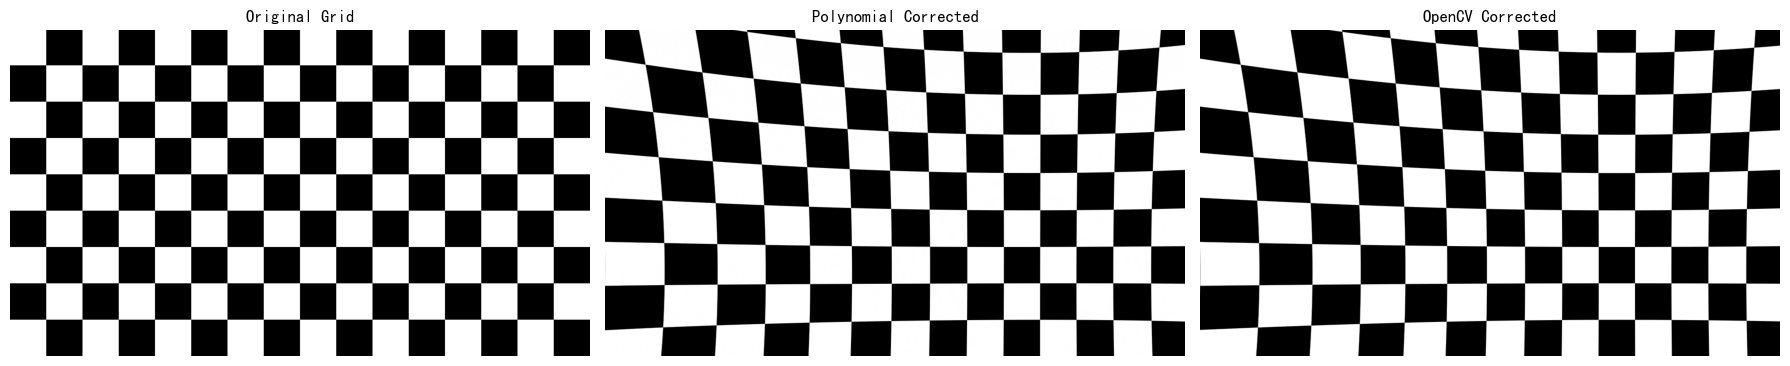

In [35]:
# 生成对比图
import matplotlib.pyplot as plt

def generate_grid_image(width, height, grid_size=80):
    img = np.zeros((height, width, 3), dtype=np.uint8)
    for y in range(0, height, grid_size):
        for x in range(0, width, grid_size):
            if ((x // grid_size) + (y // grid_size)) % 2 == 0:
                img[y:y+grid_size, x:x+grid_size] = 255
    return img

# 生成测试图像和校正对比
original_grid = generate_grid_image(1280, 720, grid_size=80)
polynomial_corrected = apply_polynomial_correction(original_grid, x_coeffs, y_coeffs)
opencv_corrected = cv2.undistort(original_grid, mtx, dist)

# 三重对比显示
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(original_grid)
ax1.set_title('Original Grid')
ax1.axis('off')

ax2.imshow(polynomial_corrected)
ax2.set_title('Polynomial Corrected')
ax2.axis('off')

ax3.imshow(opencv_corrected)
ax3.set_title('OpenCV Corrected')
ax3.axis('off')

plt.tight_layout()
plt.show()